TL;DR

Data: Top 100 movies (http://www.imdb.com/list/ls055592025/) with title, genre, and synopsis (IMDB and Wiki)
Goal: Put 100 movies into 5 clusters based on text mining their synopses

In [166]:
import numpy as np
import pandas as pd
import nltk
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

Read movie titles, 100 movies but somehow the last one is empty string

In [167]:
#create the dataframe
df = pd.read_csv ('../source/imdbMovies.csv', sep=';')
print(df)


                                           certificate       country  \
0                                                  NaN        Greece   
1    Germany:18, New Zealand:R16, Singapore:M18, Un...        Poland   
2                       Singapore:M18, United States:M        Poland   
3                                         Australia:PG         Malta   
4                                                  NaN         India   
..                                                 ...           ...   
726                                                NaN         Japan   
727                                                NaN        Poland   
728                                                NaN  South Africa   
729                                                NaN        France   
730                                                NaN         India   

                                           description  \
0    Feel Your Heartbeat: The Film is the first doc...   
1    Geralt is in t

In [168]:


titles = df[df.columns[11]]
print(titles)
#len(titles)

0                   Feel Your Heartbeat: The Film (2022)
1       The Witcher 3: Wild Hunt - Blood and Wine (2016)
2      The Witcher 3: Wild Hunt - Hearts of Stone (2015)
3                             Brothers from Malta (2022)
4                           The Priceless Moments (2021)
                             ...                        
726    Do Not Fight Even If Things Come To A Head (2019)
727                              For Our Children (2020)
728                Home Affairs: A Christmas Tale (2020)
729                        MILANKA - The Woman Who Knows
730                    Nayanthara: Beyond the Fairy Tale
Name: title, Length: 731, dtype: object


Read Genres information

In [169]:
genres = df[df.columns[4]]
genres = genres

In [170]:
genres

0            Documentary, Music
1      Action, Adventure, Drama
2      Action, Adventure, Drama
3                        Comedy
4            Documentary, Short
                 ...           
726                       Drama
727          Documentary, Short
728                       Drama
729                 Documentary
730                 Documentary
Name: genre, Length: 731, dtype: object

Read in the desc from csv

In [171]:
synopses = df[df.columns[2]]

In [172]:
synopses

0      Feel Your Heartbeat: The Film is the first doc...
1      Geralt is in the southern province of Toussain...
2      Geralt is forced by a seemingly harmless merch...
3      Denounced Maltese brothers Joe and Charlie mus...
4      A Shot Documentary of Seven best friends Known...
                             ...                        
726    Tanimura Kotaro has spent a lot of dough trave...
727    &quot;We would rummage through the rubbish for...
728    A feuding family--mother, father, and their fo...
729    An artistic and experimental documentary Film ...
730    The love story of South Indian superstar Nayan...
Name: description, Length: 731, dtype: object

strips html formatting and converts to unicode

In [173]:
synopses_clean = []
for text in synopses:
    #print(text)
    text = BeautifulSoup(text, 'html.parser').getText()
    synopses_clean.append(text)
synopses = synopses_clean

/usr/local/lib/python3.9/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [174]:
synopses[-1]

'The love story of South Indian superstar Nayanthara, who recently got married in a fairytale wedding to filmmaker Vignesh Shivan.'

In [175]:
print(str(len(titles)) + ' titles')
print(str(len(genres)) + ' genres')
print(str(len(synopses)) + ' synopses')

731 titles
731 genres
731 synopses


In [176]:
# generates index for each item in the corpora (in this case it's just rank) and I'll use this for scoring later
# the movies in the list are already ranked from 1 to 100
ranks = []
for i in range(1, len(titles)+1):
    ranks.append(i)

In [221]:
# load nltk's English stopwords as variable called 'stopwords'
# use nltk.download() to install the corpus first
# Stop Words are words which do not contain important significance to be used in Search Queries
stopwords = nltk.corpus.stopwords.words('english')

# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer("english")

In [240]:
stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [218]:
stopwordsNew = ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv']

In [239]:
stopwords.append("'s")

In [241]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
# Punkt Sentence Tokenizer, sent means sentence 
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [242]:

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized

In [243]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i) # for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) # extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [244]:
print(len(totalvocab_stemmed))
print(len(totalvocab_tokenized))

22602
22602


In [245]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')
print(vocab_frame.head())

there are 22602 items in vocab_frame
               words
feel            feel
your            your
heartbeat  heartbeat
the              the
film            film


In [246]:
print(vocab_frame)

               words
feel            feel
your            your
heartbeat  heartbeat
the              the
film            film
...              ...
wed          wedding
to                to
filmmak    filmmaker
vignesh      vignesh
shivan        shivan

[22602 rows x 1 columns]


Generate TF-IDF matrix (see http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

max_df: this is the maximum frequency within the documents a given feature can have to be used in the tfi-idf matrix. If the term is in greater than 80% of the documents it probably cares little meanining (in the context of film synopses)

min_idf: this could be an integer (e.g. 5) and the term would have to be in at least 5 of the documents to be considered. Here I pass 0.2; the term must be in at least 20% of the document. I found that if I allowed a lower min_df I ended up basing clustering on names--for example "Michael" or "Tom" are names found in several of the movies and the synopses use these names frequently, but the names carry no real meaning.

ngram_range: this just means I'll look at unigrams, bigrams and trigrams

In [253]:
# Note that the result of this block takes a while to show
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.95,min_df=0.03,
                                  stop_words=stopwords,tokenizer=tokenize_and_stem)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses) #fit the vectorizer to synopses

# (100, 563) means the matrix has 100 rows and 563 columns
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names_out()
terms

CPU times: user 486 ms, sys: 3.64 ms, total: 490 ms
Wall time: 489 ms
(731, 63)


array(['becom', 'boy', 'brother', 'child', 'come', 'daughter', 'day',
       'death', 'decid', 'end', 'fall', 'famili', 'father', 'film',
       'find', 'first', 'follow', 'forc', 'friend', 'get', 'girl', 'help',
       'home', 'husband', 'leav', 'life', 'live', 'look', 'love', 'make',
       'man', 'marri', 'meet', 'mother', 'murder', 'must', 'new', 'old',
       'one', 'onli', 'parent', 'peopl', 'play', 'return', 'school',
       'secret', 'set', 'son', 'stori', 'take', 'three', 'time', 'tri',
       'two', 'want', 'war', 'way', 'wife', 'woman', 'work', 'world',
       'year', 'young'], dtype=object)

In [230]:
from sklearn.metrics.pairwise import cosine_similarity
# A short example using the sentences above
words_vectorizer = TfidfVectorizer()

%time words_matrix = words_vectorizer.fit_transform(sents) #fit the vectorizer to synopses

# (2, 18) means the matrix has 2 rows (two sentences) and 18 columns (18 terms)
print(words_matrix.shape)
print(words_matrix)

# this is how we get the 18 terms
analyze = words_vectorizer.build_analyzer()
print(analyze("In 1431, Jeanne'Arc is placed on trial on charges of heresy."))
all_terms = words_vectorizer.get_feature_names()
print(all_terms)
print(len(all_terms))

# sent 1 and 2, similarity 0, sent 1 and 3 shares "his", sent 2 and 3 shares Vito - try to change Vito's in sent3 to His and see the similary matrix changes
example_similarity = cosine_similarity(words_matrix)
example_similarity

CPU times: user 1.53 ms, sys: 158 µs, total: 1.69 ms
Wall time: 1.54 ms
(3, 29)
  (0, 27)	0.3501387057719138
  (0, 6)	0.3501387057719138
  (0, 18)	0.3501387057719138
  (0, 10)	0.2662895107233706
  (0, 13)	0.2662895107233706
  (0, 1)	0.3501387057719138
  (0, 0)	0.3501387057719138
  (0, 16)	0.3501387057719138
  (0, 24)	0.3501387057719138
  (1, 9)	0.5174199439321682
  (1, 22)	0.39351120409397233
  (1, 4)	0.5174199439321682
  (1, 26)	0.39351120409397233
  (1, 13)	0.39351120409397233
  (2, 19)	0.22662749562200124
  (2, 21)	0.22662749562200124
  (2, 3)	0.22662749562200124
  (2, 7)	0.22662749562200124
  (2, 23)	0.22662749562200124
  (2, 2)	0.22662749562200124
  (2, 14)	0.22662749562200124
  (2, 8)	0.22662749562200124
  (2, 12)	0.22662749562200124
  (2, 25)	0.22662749562200124
  (2, 5)	0.22662749562200124
  (2, 15)	0.22662749562200124
  (2, 11)	0.22662749562200124
  (2, 17)	0.22662749562200124
  (2, 20)	0.22662749562200124
  (2, 28)	0.22662749562200124
  (2, 22)	0.17235605184694308
  (2, 26)	0

/usr/local/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[1.        , 0.10478791, 0.09179322],
       [0.10478791, 1.        , 0.13564807],
       [0.09179322, 0.13564807, 1.        ]])

Now onto the fun part. Using the tf-idf matrix, you can run a slew of clustering algorithms to better understand the hidden structure within the synopses. I first chose k-means. K-means initializes with a pre-determined number of clusters (I chose 5). Each observation is assigned to a cluster (cluster assignment) so as to minimize the within cluster sum of squares. Next, the mean of the clustered observations is calculated and used as the new cluster centroid. Then, observations are reassigned to clusters and centroids recalculated in an iterative process until the algorithm reaches convergence.

I found it took several runs for the algorithm to converge a global optimum as k-means is susceptible to reaching local optima - how to decide that the algorithm converged???

In [257]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 516 ms, sys: 38.4 ms, total: 554 ms
Wall time: 87.1 ms


I use joblib.dump to pickle the model, once it has converged and to reload the model/reassign the labels as the clusters.

In [258]:
import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()
# clusters show which cluster (0-4) each of the 100 synoposes belongs to
print(len(clusters))
print(clusters)

731
[0, 0, 0, 1, 0, 3, 2, 0, 0, 3, 2, 0, 2, 0, 0, 3, 0, 3, 0, 2, 3, 4, 2, 1, 1, 0, 3, 0, 0, 0, 2, 0, 0, 2, 0, 0, 4, 0, 3, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 3, 3, 0, 0, 3, 3, 0, 0, 3, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 0, 0, 2, 4, 3, 4, 0, 0, 3, 3, 0, 0, 0, 0, 0, 1, 4, 4, 1, 0, 2, 4, 2, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 0, 0, 0, 3, 2, 3, 0, 0, 4, 0, 0, 1, 0, 4, 0, 0, 3, 0, 1, 0, 3, 0, 2, 1, 0, 1, 1, 3, 2, 0, 0, 4, 4, 0, 1, 3, 0, 0, 0, 0, 2, 0, 3, 4, 4, 0, 3, 3, 0, 0, 0, 3, 0, 0, 0, 4, 3, 1, 2, 1, 3, 0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 1, 3, 0, 4, 2, 3, 2, 0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 1, 0, 1, 0, 3, 3, 3, 2, 0, 2, 1, 0, 4, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 3, 3, 0, 0, 0, 2, 0, 3, 3, 0, 0, 0, 0, 1, 0, 0, 4, 2, 2, 3, 0, 0, 3, 0, 0, 4, 3, 0, 0, 0, 2, 1, 3, 1, 0, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 3, 0, 3, 0, 0, 4, 0, 0, 4, 0, 0, 2, 2, 0, 0, 2, 3, 0, 3, 0, 0, 2, 0, 3, 1, 1, 0, 1, 0, 0, 4, 0, 4, 2, 0, 0, 3, 0, 1, 0, 0, 3, 0, 2, 3, 4, 1, 0, 1, 3, 3, 4, 3, 1, 0, 2, 3,

Here, I create a dictionary of titles, ranks, the synopsis, the cluster assignment, and the genre [rank and genre were scraped from IMDB].
I convert this dictionary to a Pandas DataFrame for easy access. I'm a huge fan of Pandas and recommend taking a look at some of its awesome functionality which I'll use below, but not describe in a ton of detail.

In [259]:
films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

#print(films)

frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

print(frame) # here the ranking is still 0 to 99

frame['cluster'].value_counts() #number of films per cluster (clusters from 0 to 4)

    rank title  cluster genre
0      1   NaN        0   NaN
0      2   NaN        0   NaN
0      3   NaN        0   NaN
1      4   NaN        1   NaN
0      5   NaN        0   NaN
..   ...   ...      ...   ...
0    727   NaN        0   NaN
0    728   NaN        0   NaN
1    729   NaN        1   NaN
0    730   NaN        0   NaN
4    731   NaN        4   NaN

[731 rows x 4 columns]


0    425
3    107
2     75
4     64
1     60
Name: cluster, dtype: int64

In [260]:
grouped = frame['rank'].groupby(frame['cluster']) # groupby cluster for aggregation purposes

grouped.mean() # average rank (1 to 100) per cluster

cluster
0    387.611765
1    323.100000
2    311.386667
3    326.757009
4    392.312500
Name: rank, dtype: float64

Note that clusters 4 and 0 have the lowest rank, which indicates that they, on average, contain films that were ranked as "better" on the top 100 list.
Here is some fancy indexing and sorting on each cluster to identify which are the top n (I chose n=6) words that are nearest to the cluster centroid. This gives a good sense of the main topic of the cluster.

In [261]:
from __future__ import print_function

print("Top terms per cluster:")

#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :6]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print() #add whitespace
    print() #add whitespace


Top terms per cluster:
Cluster 0 words: b'one', b'finds', b'film', b'friend', b'world', b'become',

Cluster 0 titles: nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

Cosine similarity is measured against the tf-idf matrix and can be used to generate a measure of similarity between each document and the other documents in the corpus (each synopsis among the synopses). cosine similarity 1 means the same document, 0 means totally different ones. dist is defined as 1 - the cosine similarity of each document.  Subtracting it from 1 provides cosine distance which I will use for plotting on a euclidean (2-dimensional) plane.
Note that with dist it is possible to evaluate the similarity of any two or more synopses.

In [262]:

similarity_distance = 1 - cosine_similarity(tfidf_matrix)
print(type(similarity_distance))
print(similarity_distance.shape)

<class 'numpy.ndarray'>
(731, 731)


Multidimensional scaling
Here is some code to convert the dist matrix into a 2-dimensional array using multidimensional scaling. I won't pretend I know a ton about MDS, but it was useful for this purpose. Another option would be to use principal component analysis.

In [263]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(similarity_distance)  # shape (n_components, n_samples)

print(pos.shape)
print(pos)

xs, ys = pos[:, 0], pos[:, 1]
print(type(xs))
xs

CPU times: user 40 s, sys: 42.2 s, total: 1min 22s
Wall time: 12.2 s
(731, 2)
[[-0.44144088 -0.60076763]
 [ 0.73032693  0.04512979]
 [-0.73612743  0.09654781]
 ...
 [-0.2247403   0.54893338]
 [ 0.15638998 -0.11375407]
 [-0.14001621 -0.51748259]]
<class 'numpy.ndarray'>


array([-0.44144088,  0.73032693, -0.73612743, -0.0727001 ,  0.35097965,
       -0.1334088 , -0.21558801,  0.82386591,  0.72953976, -0.13510359,
       -0.23555487, -0.81098171,  0.18384324, -0.56654906,  0.12807298,
       -0.415094  , -0.47449097,  0.07807778, -0.35044627, -0.22256516,
       -0.63457912, -0.39633522,  0.27909748, -0.04671533, -0.22295691,
        0.59482901, -0.37883731, -0.23567947,  0.59275202, -0.75058585,
       -0.28649611,  0.53431168, -0.65910891, -0.22256516, -0.65910892,
       -0.06226376, -0.47404576, -0.61489604,  0.03144078, -0.81704146,
       -0.54425987, -0.70366357,  0.72200283, -0.48602753, -0.38256404,
       -0.56647345, -0.57487507,  0.03751152,  0.42580001,  0.18942541,
       -0.09644207,  0.07202681,  0.46564071,  0.29802748,  0.05117436,
        0.27211098, -0.19611128,  0.11993586, -0.48643855,  0.75816085,
        0.32534247,  0.45975955,  0.1457765 , -0.56189949, -0.01917034,
       -0.23431673,  0.80695008,  0.30151963, -0.46148935,  0.26

Visualizing document clusters
In this section, I demonstrate how you can visualize the document clustering output using matplotlib and mpld3 (a matplotlib wrapper for D3.js).
First I define some dictionaries for going from cluster number to color and to cluster name. I based the cluster names off the words that were closest to each cluster centroid.

In [264]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'Family, home, war', 
                 1: 'Police, killed, murders', 
                 2: 'Father, New York, brothers', 
                 3: 'Dance, singing, love', 
                 4: 'Killed, soldiers, captain'}


Next, I plot the labeled observations (films, film titles) colored by cluster using matplotlib. I won't get into too much detail about the matplotlib plot, but I tried to provide some helpful commenting.

          x         y  label  \
1  0.730327  0.045130      0   
2 -0.736127  0.096548      0   
3 -0.072700  0.709164      1   
4  0.350980  0.171014      0   
5 -0.133409  0.020143      3   
6 -0.215588 -0.641235      2   
7  0.823866 -0.015060      0   
8  0.729540 -0.228186      0   
9 -0.135104 -0.418791      3   

                                               title  
1   The Witcher 3: Wild Hunt - Blood and Wine (2016)  
2  The Witcher 3: Wild Hunt - Hearts of Stone (2015)  
3                         Brothers from Malta (2022)  
4                       The Priceless Moments (2021)  
5                  Dancing Through the Shadow (2021)  
6               Legend of the Galactic Heroes (1988)  
7  Carlo Goldoni: Venezia, Gran Teatro del Mondo ...  
8                      Voynata na taralezhite (1979)  
9                                      Flames (2018)  
{0: [0, 1, 2, 4, 7, 8, 11, 13, 14, 16, 18, 25, 27, 28, 29, 31, 32, 34, 35, 37, 39, 41, 42, 43, 44, 45, 48, 51, 52, 55, 56, 58, 59

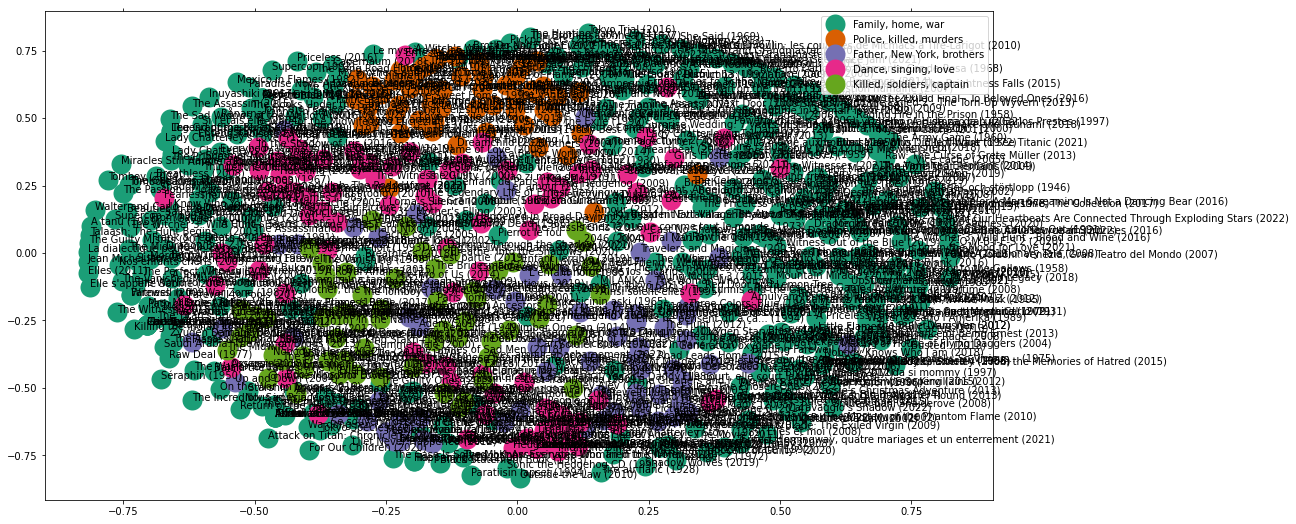

In [265]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

df.to_csv('moovies.csv')

print(df[1:10])
# group by cluster
# this generate {name:group(which is a dataframe)}
groups = df.groupby('label')
print(groups.groups)

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
# ms: marker size
for name, group in groups:
    print("*******")
    print("group name " + str(name))
    print(group)
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=20, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=10)  

    
    
#plt.show() #show the plot

#uncomment the below to save the plot if need be

plt.savefig('clusters_small_noaxes.png', dpi=200)

Use plotly to generate interactive chart. I have to downgrade matplotlib to 1.3.1 for this chart to work with plotly. see https://github.com/harrywang/plotly/blob/master/README.md for how to setup plotly. After running the following, a browser will open to show the plotly chart.

In [ ]:
 #import chart_studio.plotly as py
 #plot_url = py.plot_mpl(fig)